# Heston model: Carr-Madam method for pricing options and calibration

In [1]:
from yahooquery import Ticker
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import numpy as np

from datetime import datetime
from datetime import date
import numpy as np

from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

from scipy.integrate import quad
from scipy.optimize import minimize
from datetime import datetime as dt

import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
import random

## Background
### Fourier Transform
Recalling the Fourier Transform of a function f:
$$
\mathcal{F}[f(v)] = \int^{\infty}_{-\infty} e^{ixv}f(x)dx
$$

The Inverse Fourier Transform is given by:
$$
\mathcal{F}^{-1}[f(v)] = \frac{1}{2\pi}\int^{\infty}_{-\infty} e^{-ixv}f(x)dx
$$

For $ f \in \mathcal{L}^{2}(\mathbb{R})\text{, }\mathcal{F}^{-1}\mathcal{F}f = f$ but the inversion formula holds in other cases as well.

### DFT algorithm and FFT 
Let $x_0, ..., x_{N-1}$ be complex numbers. The DFT is defined by the formula:
$$
\begin{aligned}
y_k &= \sum^{N-1}_{m=0} x_m e^{-2\pi i\frac{mk}{N}} \quad \quad \forall k = 0, ..., N-1\\
\end{aligned}
$$

while the inverse DFT, IDFT, is defined as
$$
\begin{aligned}
x_k &= \frac{1}{N} \sum^{N-1}_{k=0} y_me^{2\pi i\frac{km}{N}} \quad \quad \forall k = 0, ..., N-1
\end{aligned}
$$

Evaluating this definition directly requires $O(n^2)$ operations: there are $n$ outputs $y_k$ , and each output requires a sum of $n$ terms. An FFT is any method to compute the same results in $O(nlogn)$ operations.
To compute FFT algorithm we will use Python's library Scipy.


### Characteristic function

Let us consider a process $X_T$ such that the underlying asset is given by:
$$
S_T = S_0\exp{(rt+X_T)}
$$

and therefore:
$$
X_T = ln\frac{S_T}{S_0} - rT
$$

and for which the characteristic function:
$$
\phi_{X_T}(v) = \mathbb{E}[e^{{ivX_T}}] = \int_{\mathbb{R}}e^{{ivX_T}}f_{X_T}(x)dx = \mathcal{F}[f_{X_T}]
$$

Here $f_{X_T}$ is the pdf, and $\mathcal{F}$ is the Fourier transform operator.

In the following we will use $\phi_T$ as short for $\phi_{X_T}$
Moreover, in the risk neutral measure, $\phi(-i) = 1$ must hold


### Characteristic function of Heston Model
Given the stochastic process:
$$
\begin{aligned}
dS_t &= \mu S_t dt + \sqrt{v_t} S_t dW_t^1 \\
dv_t &= \kappa(\theta - v_t) dt + \sigma \sqrt{v_t} dW_t^2 \\
\rho dt &= dW_t^1 dW_t^2
\end{aligned}
$$

its Characteristic function is:
$$
\begin{aligned}
\phi_{X_T}(\epsilon) &= e^{B(\epsilon) + C(\epsilon)}
\end{aligned}
$$

where:
$$
\begin{aligned}
B(\epsilon) &= \frac{2\zeta(\epsilon)(1-e^{-\psi(\epsilon)T}) V_0}{2\psi(\epsilon) - (\psi(\epsilon) - \gamma(\epsilon))(1 - e^{-\psi(\epsilon)T})}\\
C(\epsilon) &= -\frac{2\kappa\theta}{\sigma^2} \left[2\log{\left(\frac{2\psi(\epsilon) - (\psi(\epsilon) - \gamma(\epsilon))(1 - e^{-\psi(\epsilon)T})}{2\psi(\epsilon)}\right)} + (\psi(\epsilon) - \gamma(\epsilon))T\right]\\
\zeta(\epsilon) &= -\frac{1}{2}(\epsilon^2 + i\epsilon)\\
\psi(\epsilon) &= \sqrt{\gamma(\epsilon)^2 - 2\sigma^2\zeta(\epsilon)}\\
\gamma(\epsilon) &= \kappa - \rho\sigma\epsilon i
\end{aligned}
$$

In [2]:
def charFunHes_T(u, S0, v0, kappa, theta, sigma, rho, tau, r):
    gamma = kappa-rho*sigma*u*1j
    zeta = -1/2*(u**2+1j*u)
    psi = np.sqrt(gamma**2 - 2*(sigma**2)*zeta)
    C = (-2*kappa*theta/sigma**2)*(2*np.log( (2*psi-(psi-gamma)*(1-np.exp(-psi*tau))) / (2*psi)) + (psi-gamma)*tau)
    B = (2*zeta*(1-np.exp(-psi*tau))*v0)/(2*psi-(psi-gamma)*(1-np.exp(-psi*tau)))
    phi = np.exp(B+C)
    return phi



## Carr-Madam pricing method
Idea: compute the option price of call european options moving to the Fourier space, where an analytical formula is provided; then antitransform.

References: 
- Peter Carr and Dilip B. Madan, Option Valuation Using the Fast Fourier Transform, 1999 (https://engineering.nyu.edu/sites/default/files/2018-08/CarrMadan2_0.pdf)
- Rama Cont and Peter Tankov, Financial Modelling with Jump Processes, Chapman & Hall / CRC Press, 2003 (https://altexploit.files.wordpress.com/2017/07/chapman-hall_crc-financial-mathematics-series-peter-tankov-financial-modelling-with-jump-processes-crc-2003.pdf)




In what follows we denote by $k = lnK$ the log strike and assume without loss of generality that $t=0$


In ordert to compute the price of a call option:
$$
C(k) = e^{-rT} \mathbb{E}\left[(e^{rT+X_T} - e^k)^+\right]
$$

we would like to express its Fourier transform in strike in terms of the characteristic function $\phi_T(v)$ of $X_T$ and then find the prices for a range of strikes by Fourier inversion. 
However we cannot do this directly because $C(k)$ is not integrable (it tends to a positive constant as $k\rightarrow-\inf$). 

The key idea of the method is to instead compute the Fourier transform of the (modified) time value of the option, that is, the function:
$$
z_T(k) = e^{-rT} \mathbb{E}\left[(e^{rT+X_T} - e^k)^+\right] - (1-e^{k-rT})^+
$$


Let $\zeta_T(v)$ denote the Fourier transform of the time value:
$$
\zeta_T(v) = \mathcal{F}[z_T(v)] = \int^{\infty}_{-\infty} e^{ivk}z_T(k)dk
$$

It can be expressed in terms of characteristic function of $X_T$ in the following way. 

First, we note that since the discounted price process is a martingale, we can write:
$$
z_T(k) = e^{-rT}\int^{\infty}_{-\infty} (e^{rT+x} - e^k)(\mathbb{I}{k\leq x+rT} - \mathbb{I}_{k\leq rT})\rho_T(x) dx
$$

therefore:
$$
\begin{aligned}
\zeta_T(v) &= e^{-rT} \int^{\infty}_{-\infty} dk \int^{\infty}_{-\infty} e^{ivk}(e^{rT+x} - e^k)(\mathbb{I}{k\leq x+rT} - \mathbb{I}{k\leq rT})\rho_T(x) dx \\
&= e^{-rT} \int^{\infty}_{-\infty} \rho_T(x) dx \int^{rT}_{x+rT} e^{ivk}(e^k-e^{rT+x})dk \\
&= \int^{\infty}_{-\infty} \left[\frac{e^{ivrT}(1-e^x)}{iv+1} - \frac{e^{x+ivrT}}{iv(iv+1)} + \frac{e^{(iv+1)x+ivrT}}{iv(iv+1)}\right] \rho_T(x) dx \\
\end{aligned}
$$

The first term in braces disappears due to martingale condition and, after computing the other two, we conclude that:
$$
\zeta_T(v) = e^{ivrT} \frac{\Phi_T(v-i) - 1}{iv(1+iv)}
$$



In [3]:
def trasfFur_T(u, S0, v0, kappa, theta, sigma, rho, tau, r):
    phi = charFunHes_T(u-1j, S0, v0, kappa, theta, sigma, rho, tau, r)
    return np.exp(1j*u*r*tau)*(phi-1)/(1j*u*(1+1j*u))


Option prices can now be found by inverting the the Fourier transform:
$$
\begin{aligned}
z_T(k) &= \frac{1}{2\pi} \int^{\infty}_{-\infty} e^{-ivk}\zeta_T(v)dv\\
\end{aligned}
$$

and therefore:
$$
\begin{aligned}
C(k) &= z_T(k) + (1-e^{k-rT})^+
\end{aligned}
$$
We have to compute:
$$
\begin{aligned}
z_T(k) &= \frac{1}{2\pi} \int^{\infty}_{-\infty} e^{-ivk}\zeta_T(v)dv\\
\end{aligned}
$$
Since $z_T(k)$ must be real, then it holds:
$$
\begin{aligned}
z_T(k) &= \frac{1}{\pi} \int^{\infty}_{0} e^{-ivk}\zeta_T(v)dv\\
\end{aligned}
$$

Then, integrating numerically over $N$ intervals: with $\eta = A/N$, and $w_0 = w_{N-1} = \frac{1}{2}, w_j = 1$ otherwise:
$$
\begin{aligned}
z_T(k) &\approx\frac{1}{\pi} \int^{A(N-1)/N}_{0} e^{-ivk}\zeta_T(v)dv\\
\end{aligned}
$$
with $\eta = A/N$, and $w_0 = w_{N-1} = \frac{1}{2}, w_j = 1$ otherwise:
$$
\begin{aligned}
z_T(k) &\approx \frac{1}{\pi} \sum^{N-1}_{j=0} w_je^{-ijk\eta}\zeta(\eta j)\eta
\end{aligned}
$$


### Using FFT

If we now consider the following grid for the log-strike $k_l = -\lambda \frac{N}{2} + \lambda l$ with $\lambda = \frac{2\pi}{N\eta}$ and $l=0,...,N-1$, we obtain:

$$
\begin{aligned}
z_T(k) &\approx \frac{1}{\pi} \sum^{N-1}_{j=0} w_je^{-ij(-\lambda\frac{N}{2} + \lambda l)\eta}\zeta(\eta j)\eta \\
&= \frac{1}{\pi} \sum^{N-1}_{j=0} w_je^{ij\lambda\frac{N}{2}\eta} e^{-ij\lambda l\eta}\zeta(\eta j)\eta \\
&= \frac{1}{\pi} \sum^{N-1}_{j=0} w_je^{ij\pi} e^{-ijl\frac{2\pi}{N}}\zeta(\eta j)\eta \\
&=\frac{1}{\pi} \mathbb{FFT}\left[\{w_je^{ij\pi}\zeta(\eta j)\eta\}_{j=0}^{N-1}\right]
\end{aligned}
$$

In [4]:
def Zeta_k(S0, v0, kappa, theta, sigma, rho, tau, r):
    A = 600
    N = 2**13
    eta = A/N
    v = [eta*i for i in range(N)]
    v[0] = 1e-22

    FT_BS = [trasfFur_T(v[i], S0, v0, kappa, theta, sigma, rho, tau, r) for i in range(N)]
    w = np.concatenate(([0.5], np.ones(N-2), [0.5]))
    h = [w[i]*eta*FT_BS[i]*np.exp(i*1j*np.pi) for i in range(N)]

    lambda_val = 2 * np.pi / (N * eta)
    k = -lambda_val * N / 2 + lambda_val * np.arange(N)

    K = []
    maxx = [np.max([0, 1-np.exp(k[i]-r*tau)]) for i in range(N)]
    K = [S0*np.exp(k[i]) for i in range(N)]

    P = S0*np.real(fft(h)/np.pi + maxx)

    #out = [[K[i],P[i]] for i in range(N) if (K[i] > 0.1 * S0 and K[i] < 20 * S0)]
    out = [[K[i],P[i]] for i in range(N)]

    return out




Now we have a function that computes option prices given the aforementioned set of log-strike prices.


We interpolate points of the form (strike price, option price) to have a function that returns the option price given any strike price.

In [5]:
def priceCont(S0, v0, kappa, theta, sigma, rho, tau, r):

    out = Zeta_k(S0, v0, kappa, theta, sigma, rho, tau, r)
    
    K = []
    P = []
    for i in range(len(out)):
        K.append(out[i][0])
        P.append(out[i][1])

    interp_fun = interp1d(K, P)

    return interp_fun

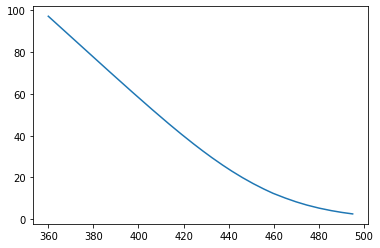

In [18]:
S0 = 450
v0, kappa, theta, sigma, rho = [1e-02,  0.5e-02, 0.5e-01,  3.915e-02,  8e-02]
r = 0.04
tau = 0.5

interp_fun = priceCont(S0, v0, kappa, theta, sigma, rho, tau, r)

x = np.linspace(S0*0.8,S0*1.1,200)

y = interp_fun(x)

plt.plot(x,y)


## Calibration
### Yield curve 

Data from: https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202311'

Reference: https://abhyankar-ameya.medium.com/yield-curve-analytics-with-python-e9254516831c

When doing the model calibration, since the risk free rate $r$ is not constant over time, one needs to take this into consideration.
We used Nelson-Sieger-Svenson parametric model to compute the zero-coupon bond yield curve. It consists of fitting the curve:

$$
r(t) = \beta_0 + (\beta_1 + \beta_2)\frac{1-e^{-\frac{t}{\tau_1}}}{\frac{t}{\tau_1}} - \beta_2 e^{-\frac{t}{\tau_1}} + \beta_3 \frac{1-e^{-\frac{t}{\tau_2}}}{\frac{t}{\tau_2}} - \beta_3 e^{-\frac{t}{\tau_2}}
$$

over data about existing coupon bonds.

To find the optimal value of the parameters, the Nelder-Mead simplex algorithm is used (already implemented in the scipy package).



NelsonSiegelSvenssonCurve(beta0=0.04982918387818083, beta1=0.006706319909786502, beta2=-0.014584878027008552, beta3=-0.008889876318298073, tau1=2.0, tau2=5.0)


"url = r'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202311'\nT = pd.read_html(url)\n\ndf = pd.DataFrame(T[0])\n\nrates = np.array(list((df.iloc[-1, 10:23].values)/100))\nprint(rates)\n\nprint(type(rates))\n\nt = np.array([1/12, 1/6, 1/4, 1/3, 1/2, 1, 2, 3, 5, 7, 10, 20, 30])\n\ncurve_fit, status = calibrate_nss_ols(t,rates)"

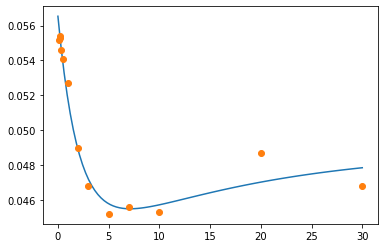

In [ ]:
t = np.array([1/12, 1/6, 1/4, 1/3, 1/2, 1, 2, 3, 5, 7, 10, 20, 30])

y = np.array([5.52/100, 5.54/100, 5.53/100, 5.46/100, 5.41/100, 5.27/100, 4.90/100, 4.68/100, 4.52/100, 4.56/100, 4.53/100, 4.87/100, 4.68/100])

#NSS model calibrate
curve_fit, status = calibrate_nss_ols(t,y)

print(curve_fit)

NSS_ZC = NelsonSiegelSvenssonCurve.zero(curve_fit, np.linspace(0,30,100))
plt.plot(np.linspace(0,30,100), NSS_ZC)
plt.plot(t,y,"o")

In [ ]:
"""url = r'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202311'
T = pd.read_html(url)

df = pd.DataFrame(T[0])

rates = np.array(list((df.iloc[-1, 10:23].values)/100))
print(rates)

print(type(rates))

t = np.array([1/12, 1/6, 1/4, 1/3, 1/2, 1, 2, 3, 5, 7, 10, 20, 30])

curve_fit, status = calibrate_nss_ols(t,rates)"""


By employing the Nelson-Siegel-Svensson (NSS) method on Zero Coupon Bonds (ZCBs), we can derive an estimation of the yield curve. 

Upon analyzing the resulting yield curve, we notice an inversion, whereas shorter-term bonds exhibit higher yields compared to longer-term ZCBs. This inversion is considered atypical and can be interpreted as a potential indicator of an impending recession. However it is coherent to the actual economical situation: for comparison, let's consider an example of a non-inverted yield curve below.



In [ ]:
"""url = r'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2021'
T = pd.read_html(url)

df = pd.DataFrame(T[-1])

rates = np.array(list((df.iloc[-1, 10:23].values)/100))
rates = np.delete(rates, 3)

t = np.array([1/12, 1/6, 1/4, 1/2, 1, 2, 3, 5, 7, 10, 20, 30])

curve_fit, status = calibrate_nss_ols(t,rates)
NSS_ZC = NelsonSiegelSvenssonCurve.zero(curve_fit, np.linspace(0,30,100))
plt.plot(np.linspace(0,30,100), NSS_ZC)
plt.plot(t,rates, 'o')"""

"url = r'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2021'\nT = pd.read_html(url)\n\ndf = pd.DataFrame(T[-1])\n\nrates = np.array(list((df.iloc[-1, 10:23].values)/100))\nrates = np.delete(rates, 3)\n\nt = np.array([1/12, 1/6, 1/4, 1/2, 1, 2, 3, 5, 7, 10, 20, 30])\n\ncurve_fit, status = calibrate_nss_ols(t,rates)\nNSS_ZC = NelsonSiegelSvenssonCurve.zero(curve_fit, np.linspace(0,30,100))\nplt.plot(np.linspace(0,30,100), NSS_ZC)\nplt.plot(t,rates, 'o')"

## Data pull

We used options data from Yahoo finance (https://finance.yahoo.com/quote/SPY/options/). 

We chose the ticker "SPY" as enough data was available but one can change it according to his preference. 

To perform the model calibration we discarded all options whose volume was less than 10.

We added columns relative to: 
- maturity as the difference between the expiration date and the current date (using the library "datetime")
- rate, computed as shown before give the expiration date


In [ ]:
# Ticker symbol for the underlying stock
underlying_ticker = "SPY"
minimum_volume = 10.0

# Retrieve options chain data from Yahoo Finance
options_chain = yf.Ticker(underlying_ticker).options
stock_data = yf.Ticker(underlying_ticker)

# Initialize an empty DataFrame to store the options data
options_data = pd.DataFrame()

# Iterate over each expiration date
for expiration_date in options_chain:
    # Get call options data for the current expiration date
    call_options_data = yf.Ticker(underlying_ticker).option_chain(expiration_date).calls
    
    # Add the expiration date column to the call options data
    call_options_data['expiration_date'] = expiration_date
    
    # Append the call options data to the options_data DataFrame
    options_data = options_data._append(call_options_data, ignore_index=True)



# Display the options_data DataFrame
selected_columns = ['expiration_date', 'strike', 'lastPrice', 'volume']
options_data = options_data[selected_columns]


today = date.today()
v=[]
u=[]
for i in options_data['expiration_date']:
     v.append((np.timedelta64(np.datetime64(i)-np.datetime64(today), 'D').astype(np.int64)/365))
     u.append(NelsonSiegelSvenssonCurve.zero(curve_fit, v[-1]))
    
options_data['maturity'] = v
options_data['rate'] = u


all_options_data = options_data[options_data['maturity'] != 0.0]
all_options_data = options_data[options_data['volume'] >= minimum_volume]

all_options_data


,expiration_date,strike,lastPrice,volume,maturity,rate
5,2023-11-27,415.0,40.20,10.0,0.002740,0.056518
9,2023-11-27,419.0,36.22,14.0,0.002740,0.056518
10,2023-11-27,420.0,35.30,15.0,0.002740,0.056518
12,2023-11-27,422.0,33.05,32.0,0.002740,0.056518
13,2023-11-27,423.0,31.98,20.0,0.002740,0.056518
...,...,...,...,...,...,...
2542,2026-01-16,530.0,23.23,17.0,2.142466,0.048552
2543,2026-01-16,535.0,21.43,11.0,2.142466,0.048552
2558,2026-01-16,615.0,4.80,10.0,2.142466,0.048552
2564,2026-01-16,660.0,1.25,743.0,2.142466,0.048552


### Training and Test dataset construction
We selected randomly (without repetition) 80% of the entries of the previous table and we tested our model on the remaining 20%

In [ ]:
import random

vector = list(all_options_data.index)

num_elements = int(len(vector) * 0.8)


# Extract 80% of the elements at random
random_elements = random.sample(vector, num_elements)

# Put the remaining 20% elements in another vector
remaining_elements = [elem for elem in vector if elem not in random_elements]

random_elements = sorted(random_elements)
remaining_elements = sorted(remaining_elements)

#Table1 = volSurfaceLong[volSurfaceLong.index == random_elements]

Training_Table = options_data.iloc[random_elements]

Test_Table = options_data.iloc[remaining_elements]

Training_Table


,expiration_date,strike,lastPrice,volume,maturity,rate
5,2023-11-27,415.0,40.20,10.0,0.002740,0.056518
9,2023-11-27,419.0,36.22,14.0,0.002740,0.056518
13,2023-11-27,423.0,31.98,20.0,0.002740,0.056518
18,2023-11-27,428.0,27.22,83.0,0.002740,0.056518
21,2023-11-27,431.0,24.12,18.0,0.002740,0.056518
...,...,...,...,...,...,...
2542,2026-01-16,530.0,23.23,17.0,2.142466,0.048552
2543,2026-01-16,535.0,21.43,11.0,2.142466,0.048552
2558,2026-01-16,615.0,4.80,10.0,2.142466,0.048552
2564,2026-01-16,660.0,1.25,743.0,2.142466,0.048552


In [ ]:
Test_Table

,expiration_date,strike,lastPrice,volume,maturity,rate
10,2023-11-27,420.0,35.30,15.0,0.002740,0.056518
12,2023-11-27,422.0,33.05,32.0,0.002740,0.056518
23,2023-11-27,433.0,22.24,20.0,0.002740,0.056518
24,2023-11-27,434.0,21.09,49.0,0.002740,0.056518
28,2023-11-27,438.0,17.00,10.0,0.002740,0.056518
...,...,...,...,...,...,...
2352,2025-06-20,570.0,5.00,11.0,1.567123,0.049896
2415,2025-12-19,350.0,133.29,24.0,2.065753,0.048708
2448,2025-12-19,515.0,28.70,13.0,2.065753,0.048708
2483,2026-01-16,210.0,250.50,16.0,2.142466,0.048552


## Calibration - Optimization Objective function

Reference: https://www.maths.univ-evry.fr/pages_perso/crepey/Finance/051111_mikh%20heston.pdf

Given:

$\Large \Theta = (v0, \kappa, \theta, \sigma, \rho)$

We want to minimize the squared error:

$\Large SqErr(\Theta) = \sum^N_{i=1}\sum^M_{j=1}w_{ij}(C_{MP}(K_i,T_j) - C_{HP}(S_0, K_i,T_j,r_j,\Theta))^2$

where: $w_{ij} = \frac{N}{M}$


$\Large \hat{\Theta} = \underset{\Theta \in U_\Theta}{arg \ min} \ SqErr(\Theta)$

Here we assume that the  set of possible combinations of parameters $U_\Theta$ is compact and in the range for which a solution exists.

Minimizing the objective function is a NLP problem with the nonlinear constrain $2\kappa\theta − \sigma^2 > 0$ known as Feller condition. This condition ensures that the volatility process cannot reach zero. Unfortunately the objective function is far from being convex and it turned out, that usually there exist many local extrema. 

We choose to minimize using scipy implemented algorithm: SLSQP



In [ ]:
# This is the calibration function
# heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
# Parameters are v0, kappa, theta, sigma, rho, lambd


# Define variables to be used in optimization
S0 = stock_data.history(period="1d")["Close"][0] # initial asset price
r = Training_Table['rate'].to_numpy('float')
K = Training_Table['strike'].to_numpy('float')
tau = Training_Table['maturity'].to_numpy('float')
P = Training_Table['lastPrice'].to_numpy('float')

params = {"v0": {"x0": 0.018293, "boundaries": [1e-3,0.1]},
          "kappa": {"x0": 0.001, "boundaries": [1e-3,5]},
          "theta": {"x0": 0.1, "boundaries": [1e-3,0.1]},
          "sigma": {"x0": 0.05830981, "boundaries": [1e-2,1]},
          "rho": {"x0": 0.0687171, "boundaries": [-1,1]},
          }

x0 = [param["x0"] for key, param in params.items()]

bnds = [param["boundaries"] for key, param in params.items()]

def Feller(x):
    v0, kappa, theta, sigma, rho = [param for param in x]
    return 2*kappa*theta - sigma**2 - 0.01

cons = {'type':'ineq', 'fun': Feller}

def SqErr(x):
    err = 0
     
    v0, kappa, theta, sigma, rho = [param for param in x]

    new_r = np.array(list(set(r)))
    new_r = np.reshape(new_r, (len(new_r), 1))

    for j in list(new_r):

        id = np.where(r == j)
        new_DF = Training_Table[Training_Table["rate"] == j[0]]
        #print(new_DF)
        strike = new_DF['strike'].tolist()
        P_new = new_DF["lastPrice"].to_numpy()

        PP = priceCont(S0, v0, j[0], kappa, theta, sigma, rho, tau[id][0])

        err = err + np.sum(np.square(np.subtract(P_new, PP(strike))))

    err = err/len(P)
    return err

result = minimize(SqErr, x0, tol = 1e-2, method='SLSQP', bounds=bnds, constraints=cons) 
"""constraints=cons"""
#result

/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_97836/2254917503.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = stock_data.history(period="1d")["Close"][0] # initial asset price


'constraints=cons'

In [ ]:
print(result)
print()
print("Feller condition:", Feller(result.x)+0.01, " > 0")

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 62.57157059619531
       x: [ 1.794e-02  1.623e-02  1.000e-01  3.915e-02  6.637e-02]
     nit: 3
     jac: [-3.547e+00  5.244e-02 -6.072e-02  2.393e-02 -1.135e+01]
    nfev: 25
    njev: 3

Feller condition: 0.001712793555798689  > 0


## Test

Mean squarered error over the test dataset is acceptable given the size of the training dataset


In [ ]:
S0 = stock_data.history(period="1d")["Close"][0] # initial asset price
r = Test_Table['rate'].to_numpy('float')
K = Test_Table['strike'].to_numpy('float')
tau = Test_Table['maturity'].to_numpy('float')
P = Test_Table['lastPrice'].to_numpy('float')

def SqErr_Test(x):
    err = 0
     
    v0, kappa, theta, sigma, rho = [param for param in x]

    size = len(K)*len(tau)
    
    err = 0

    new_r = np.array(list(set(r)))
    new_r = np.reshape(new_r, (len(new_r), 1))

    for j in list(new_r):

        id = np.where(r == j)
        new_DF = Test_Table[Test_Table["rate"] == j[0]]
        #print(new_DF)
        strike = new_DF['strike'].tolist()
        P_new = new_DF["lastPrice"].to_numpy()

        PP = priceCont(S0, v0, j[0], kappa, theta, sigma, rho, tau[id][0])

        err = err + np.sum(np.square(np.subtract(P_new, PP(strike))))

    return err/len(P)

print("Mean squared error:", SqErr_Test(result.x))

/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_97836/2316264913.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = stock_data.history(period="1d")["Close"][0] # initial asset price


Mean squared error: 37.07922512652723


## Pricing test on a single given data

Pricing options options of a given date results in a errore smaller than 6% and closer to 0 the closer we are to ATM.

This comes from the fact that the majority of the options of the dataset were closer to ATM

455.29998779296875


(0.0, 0.1)

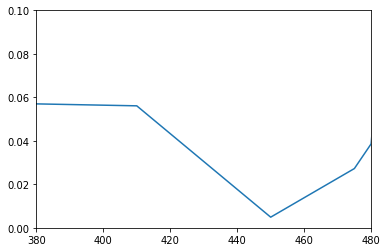

In [ ]:
#Esempio per la data "2026-01-16"

v0, kappa, theta, sigma, rho = [x for x in result.x]

dd = "2026-01-16"

print(S0)

tau = (np.timedelta64(np.datetime64(dd) - np.datetime64(date.today()),'D')).astype(np.int64)/365 # time to maturity
r = NelsonSiegelSvenssonCurve.zero(curve_fit, tau)

func = priceCont(S0, v0,kappa, theta, sigma, rho, tau,r)

K = all_options_data[all_options_data['expiration_date'] == dd]['strike']

P = all_options_data[all_options_data['expiration_date'] == dd]['lastPrice']

rel_err = np.abs(np.divide(np.subtract(func(K),P), P))

abs_err = np.abs(np.subtract(func(K),P))

plt.figure()
plt.plot(K, rel_err)
plt.xlim(380,480)
plt.ylim(0,0.1)

